# 2D case - Plotting the solution and errors
Two-parameter 2D problem - Investigation of  the  convergence  of  the  reduced-order model and of the evolution of the size of the reduced-order basis.

## Libraries import  

In [174]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(0)

## Load the config file

In [175]:
    Configuration_file = 'Configurations/config_2D_ROM.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [176]:

# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )

MaxElemSize2D = config["interpolation"]["MaxElemSize2D"] = 0.125
# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           14230



## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [177]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]],
                                    [   config["parameters"]["para_2_min"],
                                        config["parameters"]["para_2_max"],
                                        config["parameters"]["N_para_2"]]])

## Initialisation of the surrogate model

In [178]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [179]:
# ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
# ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

# ROM_model.TrainingParameters(   
#                                 loss_decrease_c = config["training"]["loss_decrease_c"], 
#                                 Max_epochs = config["training"]["n_epochs"], 
#                                 learning_rate = config["training"]["learning_rate"]
#                             )

# ROM_model.train()                                                                   # Put the model in training mode
# ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)         

ROM_model.load_state_dict(torch.load('Pretrained_models/2D_ROM', weights_only=False))

<All keys matched successfully>

## Pyvista plots

Plot the solution and the error with regard to the Finite Element solution

In [180]:
eval_coord_file = "GroundTruth/nodal_coordinates.npy"


E_vect = [0.0038,0.00314,0.00462]
theta_vect = [4.21,0,0.82]

error_vect = []
for i in range(len(E_vect)):

    num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_vect[i])+"_theta="+str(theta_vect[i])+".npy"

    eval_coord =  torch.tensor(np.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
    num_displ = torch.tensor(np.load(num_displ_file))

    theta = torch.tensor([theta_vect[i]],dtype=torch.float64)
    theta = theta[:,None] 

    E = torch.tensor([E_vect[i]],dtype=torch.float64)
    E = E[:,None] 


    Para_coord_list = nn.ParameterList((E,theta))
    ROM_model.eval()                                                        # Put model in evaluation mode
    u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model

    u_sol_x = u_sol[0,:,0,0]
    u_sol_y = u_sol[1,:,0,0]

    u_ref_x = num_displ[:,0]
    u_ref_y = num_displ[:,1]

    u_ref_tot = torch.hstack((u_ref_x,u_ref_y))
    u_sol_tot = torch.hstack((u_sol_x,u_sol_y))

    error_u_tot = (torch.linalg.vector_norm(u_sol_tot - u_ref_tot)/torch.linalg.vector_norm(u_ref_tot)).item()
    error_vect.append(error_u_tot)

In [181]:
error_vect

[0.0008721099977561525, 0.0014990741132987406, 0.0027197109293198856]

In [182]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
import torch.nn as nn

pv.global_theme.font.family = 'times'                                           # Arial, courier or times
pv.global_theme.font.size = 40
pv.global_theme.font.title_size = 40
pv.global_theme.font.label_size = 40
pv.global_theme.font.fmt = '%.2e'

filename = 'Geometries/'+Mesh_object.name_mesh                                  # Load mesh (used for projecting the solution only) 
mesh = pv.read(filename)                                                        # Create pyvista mesh    
Nodes = np.stack(Mesh_object.Nodes)  
import matplotlib
matplotlib.rcParams["font.size"] = "25"


## First parameters set

E = 0.0038, theta = 4.21, theta_deg = 241.21523175007655


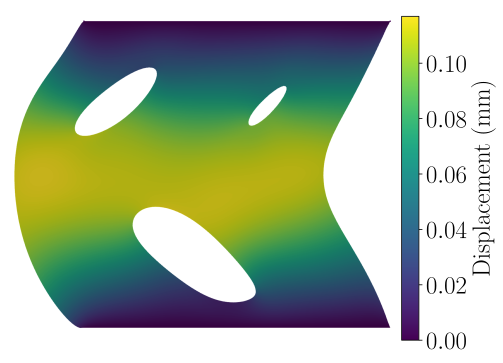

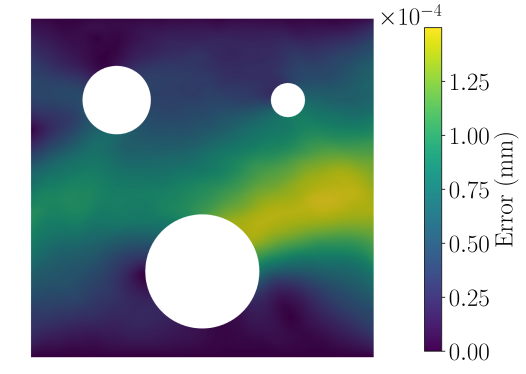

In [193]:
#Fig a)

name = 'a'

theta_i = theta_vect[0]
E_i = E_vect[0]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')


num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result a)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(250,1500)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

    ## Error a)
    plotter = pv.Plotter(off_screen=True)
    # plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis', clim=[0, 0.05],show_scalar_bar=False)
    plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis',show_scalar_bar=False)

    plotter.view_xy()

    import matplotlib
    image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
    with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
        fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
        plt.imshow(image)
        plt.xlim(900, 2500)
        plt.ylim(250,1500)
        # ax.imshow(image)
        plt.axis('off')  
        
        # fig.subplots_adjust(right=1)  
        cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


        # Normalize scalar field values for the color bar
        norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
        # cmap = cm.get_cmap('viridis')
        cmap = matplotlib.colormaps['viridis']

        # Add a color bar based on the normalization and the colormap
        cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
        cbar.set_label('Error (mm)', fontsize=25)
        cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
        cbar.update_ticks()  # Update the ticks after setting the formatter
        
        # Save the figure as a vectorized PDF
        pdf.savefig(fig,bbox_inches = 'tight')
        plt.show(fig)
        plt.close(fig)

## Second parameters set

E = 0.00314, theta = 0, theta_deg = 0.0


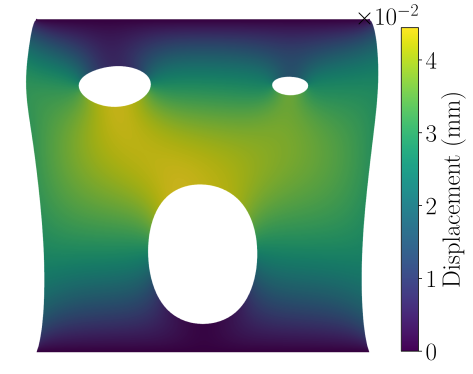

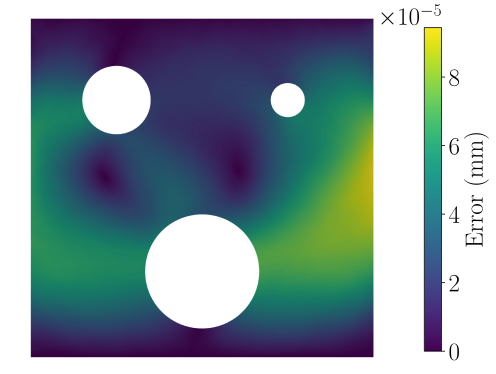

In [192]:
#Fig b)

name = 'b'

theta_i = theta_vect[1]
E_i = E_vect[1]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')


num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result b)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(250,1500)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

    ## Error a)
    plotter = pv.Plotter(off_screen=True)
    # plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis', clim=[0, 0.05],show_scalar_bar=False)
    plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis',show_scalar_bar=False)

    plotter.view_xy()

    import matplotlib
    image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
    with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
        fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
        plt.imshow(image)
        plt.xlim(900, 2500)
        plt.ylim(250,1500)
        # ax.imshow(image)
        plt.axis('off')  
        
        # fig.subplots_adjust(right=1)  
        cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


        # Normalize scalar field values for the color bar
        norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
        # cmap = cm.get_cmap('viridis')
        cmap = matplotlib.colormaps['viridis']

        # Add a color bar based on the normalization and the colormap
        cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
        cbar.set_label('Error (mm)', fontsize=25)
        cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
        cbar.update_ticks()  # Update the ticks after setting the formatter
        
        # Save the figure as a vectorized PDF
        pdf.savefig(fig,bbox_inches = 'tight')
        plt.show(fig)
        plt.close(fig)

## Third parameters set

E = 0.00462, theta = 0.82, theta_deg = 46.9825392007275


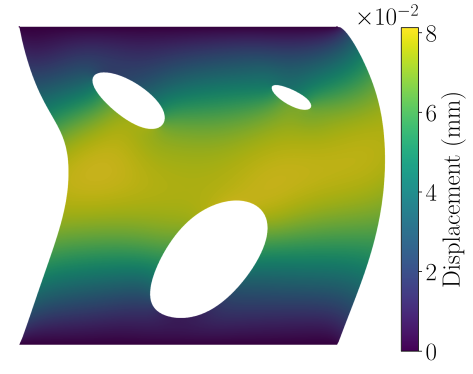

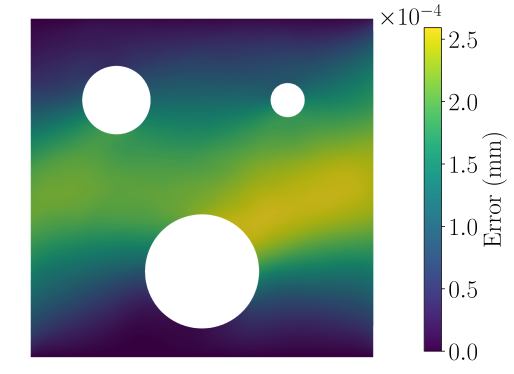

In [191]:
#Fig c)

name = 'c'

theta_i = theta_vect[2]
E_i = E_vect[2]

print(f'E = {E_i}, theta = {theta_i}, theta_deg = {theta_i*180/np.pi}')

num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_i)+"_theta="+str(theta_i)+".npy"

num_displ = torch.tensor(np.load(num_displ_file))

theta = torch.tensor([theta_i],dtype=torch.float64)
theta = theta[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,theta))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
u_ref  = torch.stack([(num_displ[:,0]),(num_displ[:,1]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)
error_ref = torch.abs(u-u_ref)

mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data
mesh.point_data['error'] = error_ref.data
mesh.point_data['error_norm'] = torch.norm(error_ref, dim=1).data

## Result c)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()

import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(250,1500)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)

    ## Error a)
    plotter = pv.Plotter(off_screen=True)
    # plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis', clim=[0, 0.05],show_scalar_bar=False)
    plotter.add_mesh(mesh.warp_by_vector(vectors="error",factor=20,inplace=False), scalars='error_norm', cmap='viridis',show_scalar_bar=False)

    plotter.view_xy()

    import matplotlib
    image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
    with PdfPages('Results/Fig_pyvista_error_'+name+'.pdf') as pdf:
        fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
        plt.imshow(image)
        plt.xlim(900, 2500)
        plt.ylim(250,1500)
        # ax.imshow(image)
        plt.axis('off')  
        
        # fig.subplots_adjust(right=1)  
        cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5]) 


        # Normalize scalar field values for the color bar
        norm = Normalize(vmin=mesh.point_data['error_norm'].min(), vmax=mesh.point_data['error_norm'].max())
        # cmap = cm.get_cmap('viridis')
        cmap = matplotlib.colormaps['viridis']

        # Add a color bar based on the normalization and the colormap
        cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
        cbar.set_label('Error (mm)', fontsize=25)
        cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
        cbar.update_ticks()  # Update the ticks after setting the formatter
        
        # Save the figure as a vectorized PDF
        pdf.savefig(fig,bbox_inches = 'tight')
        plt.show(fig)
        plt.close(fig)